In [1]:

# RESNET_SE_MODEL_URL = "https://uberduck-models-us-west-2.s3.us-west-2.amazonaws.com/coqui/resnet_se.pth.tar"
# RESNET_SE_CONFIG_URL = "https://uberduck-models-us-west-2.s3.us-west-2.amazonaws.com/coqui/resnet_se_config.json"

resnet_se_model = '/usr/src/app/radtts/resnet_se.pth.tar'
resnet_se_config = '/usr/src/app/radtts/resnet_se_config.json'

import torch
import json
# from uberduck_ml_dev import TTS 
with open(resnet_se_config) as f:
    resnet_config =json.load(f)
    
state_dict = torch.load(resnet_se_model)['model']
# def get_pretrained_model():
#     print("Getting model config...")
#     response = requests.get(RESNET_SE_CONFIG_URL)
#     resnet_config = response.json()
#     model_params = resnet_config["model_params"]
#     if "model_name" in model_params:
#         del model_params["model_name"]
audio_config = dict(resnet_config["audio"])
model_params = resnet_config["model_params"]
if "model_name" in model_params:
    del model_params["model_name"]

audio_config["sample_rate"] = 22050
from TTS.encoder.models.resnet import ResNetSpeakerEncoder
model = ResNetSpeakerEncoder(**model_params, audio_config=audio_config)
#     print("Loading pretrained model...")
#     load_pretrained(model)
#     print("Got pretrained model...")
#     model.eval()
#     return model
model.cuda()
model.eval()
model.load_state_dict(state_dict)

<All keys matched successfully>

In [2]:
for _param in model.parameters():
    _param.requires_grad = False

In [17]:
# filelist_path = "/usr/src/app/radtts/data/combined_030223_clean_small_22k_normalized.txt"
filelist_path = '/usr/src/app/radtts/data/30_decoder_pitch.txt'
import pandas as pd
data = pd.read_csv(filelist_path, index_col = None, header = None, sep = '|')

In [18]:
from scipy.io.wavfile import read
audio_datas = [read(path)[1] for path in data[0]]
model.eval()
model.cuda()

from tqdm import tqdm
embs = []
with torch.no_grad():
    for audio_data in tqdm(audio_datas):
        datum = torch.FloatTensor(audio_data).unsqueeze(-1).t().cuda()
        embs.append(model(datum))

100%|██████████| 21787/21787 [03:06<00:00, 116.52it/s]


In [19]:
embeddings = torch.vstack(embs)

In [21]:
torch.save(embeddings, '/usr/src/app/uberduck_local/30_speaker_embeddings.pt')

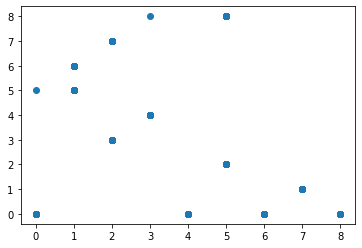

In [8]:

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
%matplotlib inline
kmeans = KMeans(n_clusters=9)
kmeans.fit(embeddings.cpu())
plt.scatter(kmeans.labels_, data[2])

In [10]:
import umap
reducer = umap.UMAP(n_components=5)
embedding = reducer.fit_transform(embeddings.cpu())
embedding = pd.DataFrame(embedding, columns = list(range(10,15)))
asdf = pd.concat([pd.DataFrame(embedding), pd.DataFrame(data[2])], axis = 1)


In [11]:
import seaborn as sns

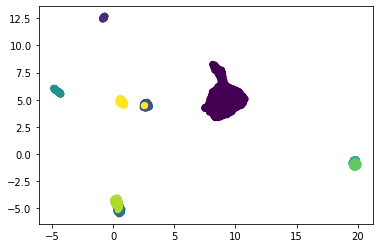

In [16]:
plt.scatter(embedding[10], embedding[11], c= data[2])

In [15]:
embedding

,10,11,12,13,14
0,8.904212,5.225513,3.373442,4.840715,5.185726
1,9.283700,5.538803,1.301725,4.512561,4.687490
2,8.756117,5.139591,3.422956,4.422959,5.381274
3,8.792906,5.094810,3.444287,4.348470,5.379850
4,9.255194,4.968653,3.416519,4.975088,5.352066
...,...,...,...,...,...
15729,0.814425,4.636143,12.587701,5.814553,4.229843
15730,0.745936,4.597736,12.490961,5.728401,4.172289
15731,0.625443,4.767930,12.550723,5.903086,4.138015
15732,0.759916,4.633164,12.555181,5.757710,4.206126


In [12]:
sns.pairplot(asdf, hue = 2, palette="viridis")

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3441, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-a1d8695c6f25>", line 1, in <module>
    sns.pairplot(asdf, hue = 2, palette="viridis")
  File "/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py", line 2172, in pairplot
    grid.add_legend()
  File "/opt/conda/lib/python3.8/site-packages/seaborn/axisgrid.py", line 198, in add_legend
    _draw_figure(self._figure)
  File "/opt/conda/lib/python3.8/site-packages/seaborn/utils.py", line 80, in _draw_figure
    fig.canvas.draw()
  File "/opt/conda/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py", line 406, in draw
    self.figure.draw(self.renderer)
  File "/opt/conda/lib/python3.8/site-packages/matplotlib/artist.py", line 74, in draw_wrapper
    result = draw(artist, renderer, *args, **kwargs)
  File "/opt/conda/lib/python3.8/site-packages/matplotli

TypeError: object of type 'NoneType' has no len()

Error in callback <function flush_figures at 0x7fe7db074ca0> (for post_execute):


KeyboardInterrupt: 

<AxesSubplot:>

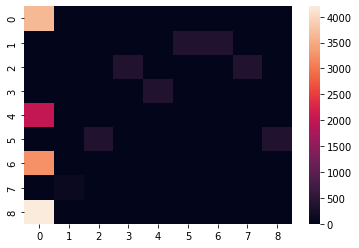

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(kmeans.labels_, data[2]))